<a href="https://colab.research.google.com/github/VictoriaReiShiro/grid_quality_metrics_pithon/blob/master/2D_elem_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving f00001_2D.inp to f00001_2D.inp


In [ ]:
pip install meshio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 3.6 MB/s eta 0:00:00


**Преобразование inp-файлов в vtu-файлы**

In [ ]:
import meshio

# Чтение INP-файла
mesh = meshio.read("f00001_2D.inp")

# Запись в VTU-формат
meshio.write("f00001_2D.vtu", mesh)

Info: VTU format cannot write cell_sets. Converting them to cell_data...

In [ ]:
pip install vtk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 8.1 MB/s eta 0:00:00


**Определение типа элементов сетки**

In [ ]:
import vtk
from vtk.util import numpy_support
import numpy as np

def check_vtu_elements(filename):
    # Загрузка файла .vtu
    reader = vtk.vtkXMLUnstructuredGridReader()
    reader.SetFileName(filename)
    reader.Update()

    # Получение сетки
    unstructured_grid = reader.GetOutput()

    # Проверка наличия данных
    if unstructured_grid is None:
        print("Ошибка: не удалось загрузить сетку из файла.")
        return

    # Получение информации о ячейках (элементах)
    cells = unstructured_grid.GetCells()
    cell_types = unstructured_grid.GetCellTypesArray()

    if cell_types is None:
        print("Файл не содержит элементов (ячеек).")
        return

    # Преобразование типов ячеек в массив numpy
    cell_types_np = numpy_support.vtk_to_numpy(cell_types)

    # Уникальные типы элементов
    unique_cell_types = np.unique(cell_types_np)

    # Соответствие VTK-кодов типам элементов
    vtk_cell_types = {
        1: "VTK_VERTEX (вершина)",
        2: "VTK_POLY_VERTEX (набор вершин)",
        3: "VTK_LINE (линия, 2 точки)",
        4: "VTK_POLY_LINE (ломаная линия)",
        5: "VTK_TRIANGLE (треугольник)",
        6: "VTK_TRIANGLE_STRIP (триангуляционная полоса)",
        7: "VTK_POLYGON (многоугольник)",
        8: "VTK_PIXEL (пиксель, 4 точки)",
        9: "VTK_QUAD (четырёхугольник)",
        10: "VTK_TETRA (тетраэдр)",
        11: "VTK_VOXEL (воксель, 8 точек)",
        12: "VTK_HEXAHEDRON (гексаэдр/куб)",
        13: "VTK_WEDGE (призма)",
        14: "VTK_PYRAMID (пирамида)",
        15: "VTK_QUADRATIC_EDGE (квадратичный отрезок)",
        16: "VTK_QUADRATIC_TRIANGLE (квадратичный треугольник)",
        17: "VTK_QUADRATIC_QUAD (квадратичный четырёхугольник)",
        18: "VTK_QUADRATIC_TETRA (квадратичный тетраэдр)",
        19: "VTK_QUADRATIC_HEXAHEDRON (квадратичный гексаэдр)"
    }

    print("Типы элементов в файле:")
    for cell_type in unique_cell_types:
        if cell_type in vtk_cell_types:
            print(f"  - {vtk_cell_types[cell_type]} (VTK-код: {cell_type})")
        else:
            print(f"  - Неизвестный тип (VTK-код: {cell_type})")

# Пример использования
filename = "f00001_2D.vtu"
check_vtu_elements(filename)

Типы элементов в файле:
  - VTK_QUAD (четырёхугольник) (VTK-код: 9)


**Подсчёт метрик для 2D**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import distance
from numpy.linalg import norm

#Вычисление метрик качества для четырёхугольника
def calc_quad_quality_metrics(points):

    # Рёбра четырёхугольника
    edges = [
        distance.euclidean(points[0], points[1]),
        distance.euclidean(points[1], points[2]),
        distance.euclidean(points[2], points[3]),
        distance.euclidean(points[3], points[0])
    ]

    # Диагонали
    diag1 = distance.euclidean(points[0], points[2])
    diag2 = distance.euclidean(points[1], points[3])

    # Площадь (через векторное произведение)
    vec1 = points[1] - points[0]
    vec2 = points[3] - points[0]
    S = 0.5 * np.linalg.norm(np.cross(vec1, vec2))

    # Углы между рёбрами
    def angle_between_vecs(v1, v2):
        return np.degrees(np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))))

    angles = [
        angle_between_vecs(points[1] - points[0], points[3] - points[0]),
        angle_between_vecs(points[2] - points[1], points[0] - points[1]),
        angle_between_vecs(points[3] - points[2], points[1] - points[2]),
        angle_between_vecs(points[0] - points[3], points[2] - points[3])
    ]

     # Искажение
    avg_edge = np.mean(edges)
    ideal_S = avg_edge ** 2
    distortion = S / ideal_S if ideal_S > 0 else 0

    # Определитель якобиана
    jacobian_det = S  # Для плоских элементов это корректно

    # Растяжение
    stretch = min(edges) / max(edges) if max(edges) > 0 else 0

    # Коэффициент формы
    shape_factor = 4 * np.sqrt(S) / np.sum(edges) if np.sum(edges) > 0 else 0

    # Объём (для 2D элементов равен площади)
    V = S

    metrics = {
        'aspect_ratio': max(edges) / min(edges) if min(edges) > 0 else float('inf'), # соотношение сторон
        'min_edge': min(edges), # самое короткое ребро
        'max_edge': max(edges), # самое длинное ребро
        'area': S, # площадь
        'diagonal_ratio': diag1 / diag2 if diag2 > 0 else float('inf'), # соотношение диагоналей
        'min_angle': min(angles), # минимальный угол
        'max_angle': max(angles), # максимальный угол
        'angle_deviation': max(abs(angle - 90) for angle in angles),  # максимальное отклонение углов от 90°
        'distortion': distortion, # искажение
        'jacobian_det': jacobian_det, # определитель якобиана
        'stretch': stretch, # растяжение
        'shape_factor': shape_factor, # коэффициент формы
        'volume': V
    }
    return metrics

# Анализ качества четырёхугольной сетки

def analyz_quad_mesh(filename):
    mesh = meshio.read(filename)
    points = mesh.points
    results = []
    quad_count = 0

    for cell in mesh.cells:
        if cell.type == "quad":
            quad_count = len(cell.data)
            for i, quad in enumerate(cell.data):
                element_points = points[quad]
                metrics = calc_quad_quality_metrics(element_points)
                metrics['elem_id'] = f"elem_{i}"
                results.append(metrics)

    if results:
        df = pd.DataFrame(results).set_index('elem_id')
        return df, quad_count
    else:
        return pd.DataFrame(), 0

quality_df, num_elem = analyz_quad_mesh(filename)
if not quality_df.empty:
    print(f"Общее число элементов сетки: {num_elem}")
else:
    print("В сетке не найдено четырёхугольных элементов")

Общее число элементов сетки: 5476


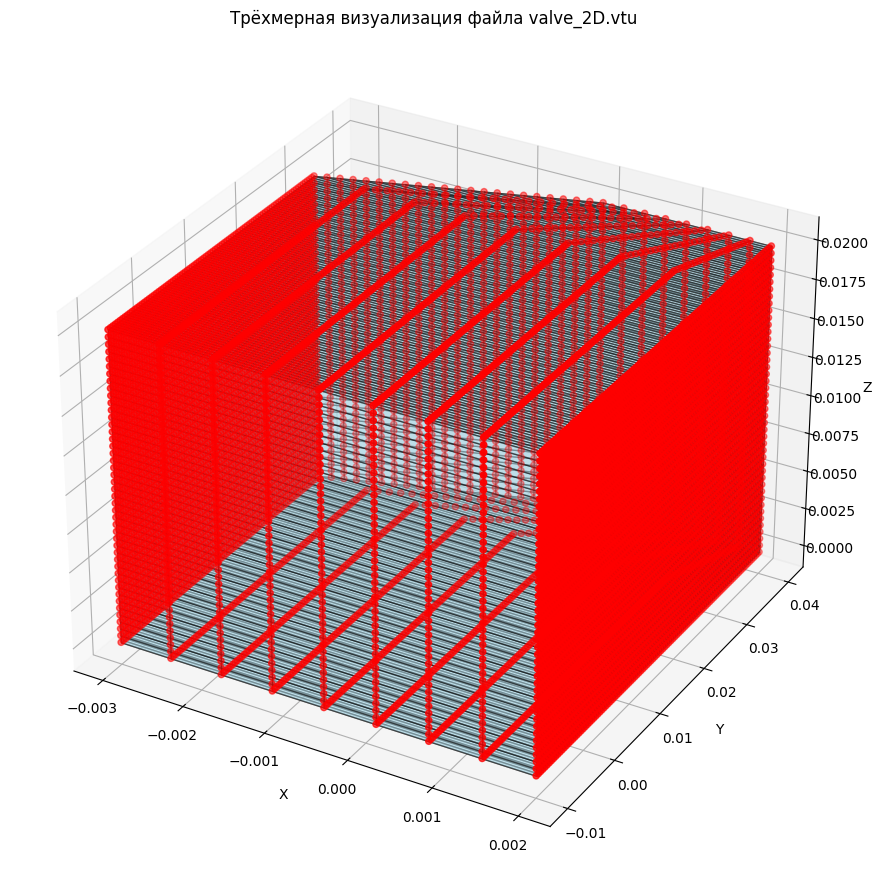

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import distance

# Визуализация четырёхугольной сетки
def visualiz_quad_mesh_3d(filename):
    mesh = meshio.read(filename)
    points = mesh.points

    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    for cell in mesh.cells:
        if cell.type == "quad":
            for quad in cell.data:
                # Координаты узлов четырёхугольника
                quad_points = points[quad]
                # Отрисовка четырёхугольника
                pol = Poly3DCollection([quad_points], alpha=0.5, linewidths=1, edgecolor='k')
                pol.set_facecolor('lightblue')
                ax.add_collection3d(pol)

    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='red', s=20)
    ax.set_title('Трёхмерная визуализация файла valve_2D.vtu')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.tight_layout()
    plt.show()

visualiz_quad_mesh_3d(filename)

Квантили метрики 'aspect_ratio':
Min: 1.01, 25%: 1.05, 50%: 1.07, 75%: 1.11, Max: 1.88


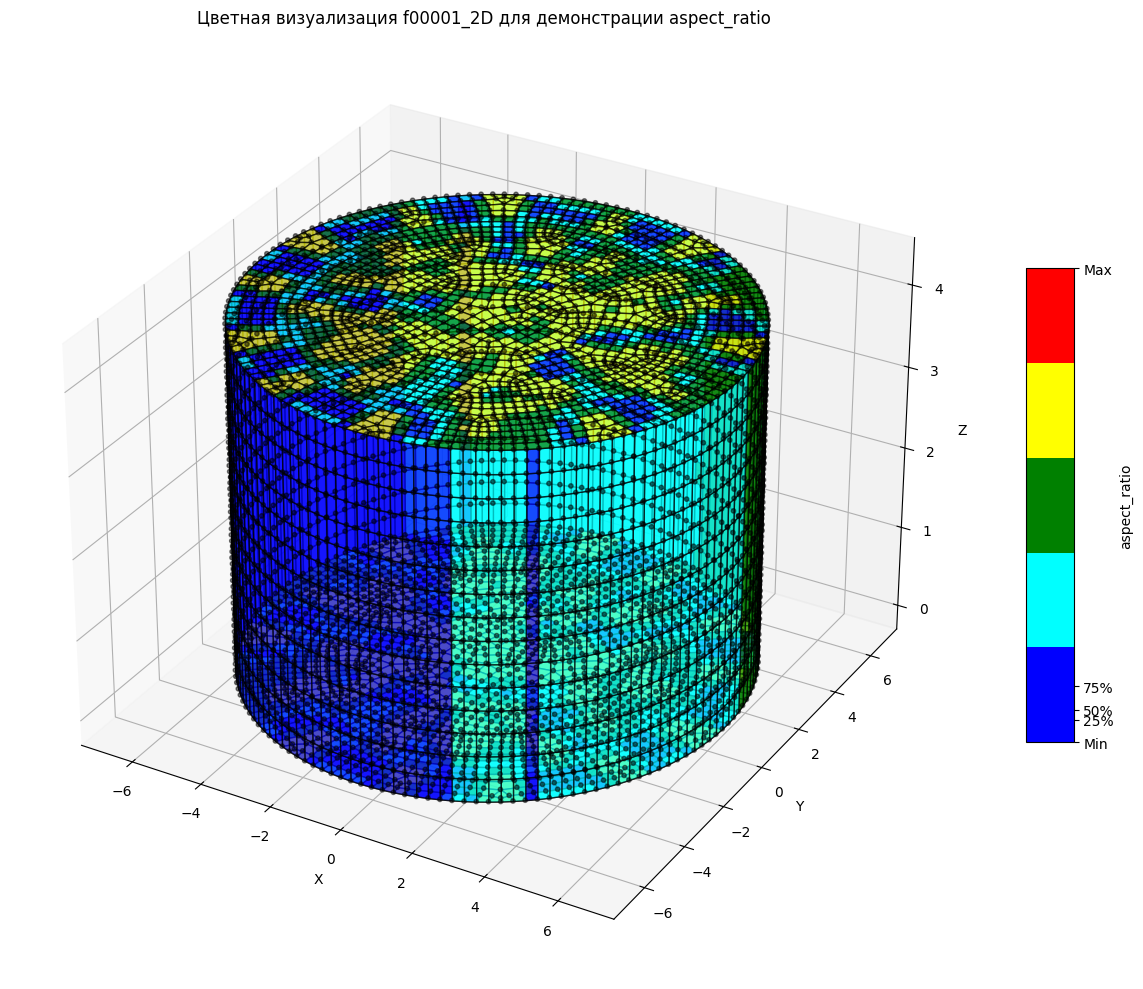

In [ ]:
from matplotlib.colors import ListedColormap

def visualiz_quad_color_mesh(filename, metric='aspect_ratio'):
    mesh = meshio.read(filename)
    points = mesh.points

    # Анализ метрик (теперь явно берем первый элемент кортежа - DataFrame)
    quality_res = analyz_quad_mesh(filename)
    quality_df = quality_res[0]  # Предполагаем, что DataFrame - первый элемент кортежа

    if quality_df.empty:
        print("Нет четырёхугольных элементов для визуализации.")
        return

    # Получение квантилей для выбранной метрики
    quantil = quality_df[metric].quantile([0, 0.25, 0.5, 0.75, 1]).values
    print(f"Квантили метрики '{metric}':\nMin: {quantil[0]:.2f}, 25%: {quantil[1]:.2f}, "
          f"50%: {quantil[2]:.2f}, 75%: {quantil[3]:.2f}, Max: {quantil[4]:.2f}")

    # Цветовая карта
    colors = ['blue', 'cyan', 'green', 'yellow', 'red']
    cmap = ListedColormap(colors)

    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Создаем словарь для соответствия индексов элементов
    elem_count = 0
    elem_id = {}

    for cell in mesh.cells:
        if cell.type == "quad":
            for quad in cell.data:
                elem_id[elem_count] = quad
                elem_count += 1

    # Проверяем соответствие количества элементов
    if len(elem_id) != len(quality_df):
        print("Количество элементов в сетке не совпадает с количеством метрик!")
        print(f"Элементов в сетке: {len(elem_id_map)}, метрик: {len(quality_df)}")
        return

    # Визуализация
    for elem_idx, quad in elem_id.items():
        quad_points = points[quad]
        # Получаем метрику по порядковому номеру элемента
        metric_val = quality_df.iloc[elem_idx][metric]

        # Определение цвета по квантилям
        if metric_val <= quantil[1]:  # 0-25%
            color = colors[0]
        elif metric_val <= quantil[2]:  # 25-50%
            color = colors[1]
        elif metric_val <= quantil[3]:  # 50-75%
            color = colors[2]
        elif metric_val <= quantil[4]:  # 75-100%
            color = colors[3]
        else:
            color = colors[4]  # На случай выбросов

        # Отрисовка четырёхугольника
        pol = Poly3DCollection([quad_points], alpha=0.7, linewidths=1, edgecolor='k')
        pol.set_facecolor(color)
        ax.add_collection3d(pol)

    # Добавление цветовой шкалы
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=quantil[0], vmax=quantil[4]))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.5, aspect=10, label=metric)
    cbar.set_ticks(quantil)
    cbar.set_ticklabels(['Min', '25%', '50%', '75%', 'Max'])

    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='black', s=10, alpha=0.5)
    ax.set_title(f'Цветная визуализация f00001_2D для демонстрации {metric}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.tight_layout()
    plt.show()

# Визуализация с аспектным соотношением (по умолчанию)
visualiz_quad_color_mesh(filename, metric='aspect_ratio')

In [ ]:
pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 2.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
# Анализ качества четырёхугольной сетки
def analyz_quad_mesh(filename):
    try:
        mesh = meshio.read(filename)
        points = mesh.points
        results = []
        elem_counter = 0

        for cell in mesh.cells:
            if cell.type == "quad":
                for quad in cell.data:
                    elem_counter += 1
                    elem_points = points[quad]
                    metrics = calc_quad_quality_metrics(elem_points)
                    if metrics is not None:
                        metrics['ID'] = f"{elem_counter}"
                        results.append(metrics)

        if results:
            df = pd.DataFrame(results).set_index('ID')

            stats = pd.DataFrame({
                'mean': df.mean(), # Среднее значение по каждой метрике
                'std': df.std(), # Стандартное отклонение (разброс значений)
            }).T

            return df, stats
        else:
            print("В сетке не найдены четырёхугольные элементы.")
            return pd.DataFrame(), pd.DataFrame()
    except Exception as e:
        print(f"Ошибка при анализе сетки: {e}")
        return pd.DataFrame(), pd.DataFrame()

if __name__ == "__main__":

    # Анализ качества
    quality_df, stats_df = analyz_quad_mesh(filename)

    if not quality_df.empty:
        print("\nМетрики качества для каждого элемента:")
        print(quality_df)

        print("\nСтатистика по метрикам:")
        print(stats_df)

        # Сохранение результатов в файл
        quality_df.to_csv('mesh_all_metrics.csv')
        stats_df.to_csv('mesh_stats.csv')


Метрики качества для каждого элемента:
      aspect_ratio  min_edge  max_edge      area  diagonal_ratio  min_angle  \
ID                                                                            
1         1.153371  0.263139  0.303496  0.043926        1.199558  74.039367   
2         1.245494  0.242859  0.302480  0.044624        1.004471  78.528807   
3         1.502474  0.259169  0.389394  0.065722        1.212031  65.379550   
4         1.208156  0.307341  0.371315  0.063027        1.087982  78.446005   
5         1.562052  0.194293  0.303496  0.019793        0.797633  66.347732   
...            ...       ...       ...       ...             ...        ...   
5472      1.085447  0.280895  0.304897  0.044549        1.002511  88.764146   
5473      1.085556  0.279371  0.303273  0.044448        1.001184  88.627784   
5474      1.087001  0.279415  0.303724  0.044608        1.001020  88.472411   
5475      1.090149  0.280417  0.305697  0.044902        1.000585  88.514590   
5476      1.


Все метрики (13 шт.):
['aspect_ratio', 'min_edge', 'max_edge', 'area', 'diagonal_ratio', 'min_angle', 'max_angle', 'angle_deviation', 'distortion', 'jacobian_det', 'stretch', 'shape_factor', 'volume']

Матрица парных коэффициентов корреляции
+-----------------+----------------+------------+------------+--------+------------------+-------------+-------------+-------------------+--------------+----------------+-----------+----------------+----------+
|                 |   aspect_ratio |   min_edge |   max_edge |   area |   diagonal_ratio |   min_angle |   max_angle |   angle_deviation |   distortion |   jacobian_det |   stretch |   shape_factor |   volume |
+=================+================+============+============+========+==================+=============+=============+===================+==============+================+===========+================+==========+
| aspect_ratio    |          100.0 |       62.4 |       22.4 |   32.1 |              8.2 |        85.9 |        86.3 |      

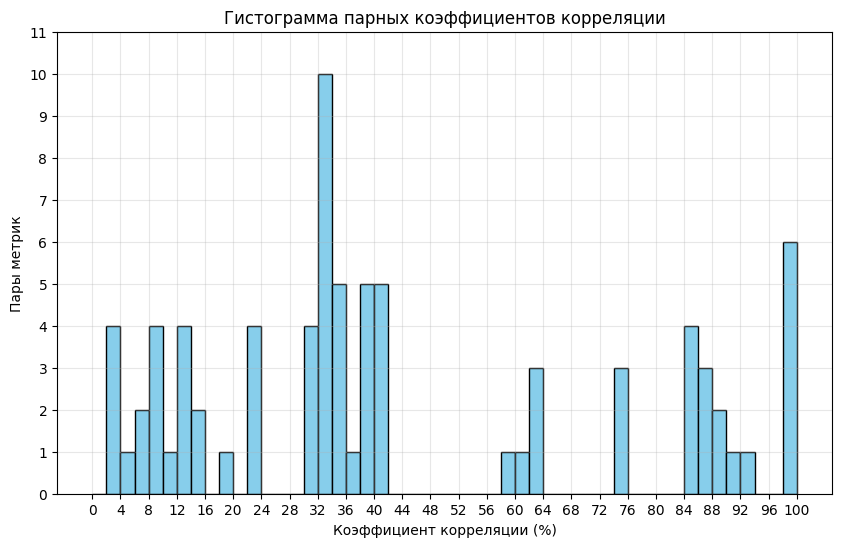

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import distance
from numpy.linalg import norm
from tabulate import tabulate
import numpy as np
import meshio


# Вычисление метрик качества для четырёхугольника
def calc_quad_quality_metrics(points):
    # Рёбра четырёхугольника
    edges = [
        distance.euclidean(points[0], points[1]),
        distance.euclidean(points[1], points[2]),
        distance.euclidean(points[2], points[3]),
        distance.euclidean(points[3], points[0])
    ]

    # Диагонали
    diag1 = distance.euclidean(points[0], points[2])
    diag2 = distance.euclidean(points[1], points[3])

    # Площадь (через векторное произведение)
    vec1 = points[1] - points[0]
    vec2 = points[3] - points[0]
    S = 0.5 * np.linalg.norm(np.cross(vec1, vec2))

    # Углы между рёбрами
    def angle_between_vecs(v1, v2):
        return np.degrees(np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))))

    angles = [
        angle_between_vecs(points[1] - points[0], points[3] - points[0]),
        angle_between_vecs(points[2] - points[1], points[0] - points[1]),
        angle_between_vecs(points[3] - points[2], points[1] - points[2]),
        angle_between_vecs(points[0] - points[3], points[2] - points[3])
    ]

    # Искажение
    avg_edge = np.mean(edges)
    ideal_S = avg_edge ** 2
    distortion = S / ideal_S if ideal_S > 0 else 0

    # Определитель якобиана
    jacobian_det = S

    # Растяжение
    stretch = min(edges) / max(edges) if max(edges) > 0 else 0

    # Коэффициент формы
    shape_factor = 4 * np.sqrt(S) / np.sum(edges) if np.sum(edges) > 0 else 0

    # Объём (для 2D элементов равен площади)
    V = S

    metrics = {
        'aspect_ratio': max(edges) / min(edges) if min(edges) > 0 else float('inf'),
        'min_edge': min(edges),
        'max_edge': max(edges),
        'area': S,
        'diagonal_ratio': diag1 / diag2 if diag2 > 0 else float('inf'),
        'min_angle': min(angles),
        'max_angle': max(angles),
        'angle_deviation': max(abs(angle - 90) for angle in angles),
        'distortion': distortion,
        'jacobian_det': jacobian_det,
        'stretch': stretch,
        'shape_factor': shape_factor,
        'volume': V
    }
    return metrics


def analyz_quad_mesh(filename):
    mesh = meshio.read(filename)
    points = mesh.points
    results = []
    quad_count = 0

    for cell in mesh.cells:
        if cell.type == "quad":
            quad_count = len(cell.data)
            for i, quad in enumerate(cell.data):
                element_points = points[quad]
                metrics = calc_quad_quality_metrics(element_points)
                metrics['elem_id'] = f"elem_{i}"
                results.append(metrics)

    if results:
        df = pd.DataFrame(results).set_index('elem_id')
        return df, quad_count
    else:
        return pd.DataFrame(), 0



#Сокращение числа метрик на основе парного корреляционного анализа

# Вывод таблицы корреляции в процентах
def print_correlation_table(quality_df):
    corr_matrix = quality_df.corr().abs()
    # Преобразование в проценты с точностью до десятых
    corr_matrix_percent = (corr_matrix * 100).round(1)
    print("\nМатрица парных коэффициентов корреляции")
    print(tabulate(corr_matrix_percent, headers=corr_matrix_percent.columns,
        tablefmt="grid", showindex=True, floatfmt=".1f"))


# Вычисление метрик качества для четырёхугольника
def calc_quad_quality_metrics(points):
    edges = [
        distance.euclidean(points[0], points[1]),
        distance.euclidean(points[1], points[2]),
        distance.euclidean(points[2], points[3]),
        distance.euclidean(points[3], points[0])
    ]

    diag1 = distance.euclidean(points[0], points[2])
    diag2 = distance.euclidean(points[1], points[3])

    vec1 = points[1] - points[0]
    vec2 = points[3] - points[0]
    S = 0.5 * np.linalg.norm(np.cross(vec1, vec2))

    def angle_between_vecs(v1, v2):
        return np.degrees(np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))))

    angles = [
        angle_between_vecs(points[1] - points[0], points[3] - points[0]),
        angle_between_vecs(points[2] - points[1], points[0] - points[1]),
        angle_between_vecs(points[3] - points[2], points[1] - points[2]),
        angle_between_vecs(points[0] - points[3], points[2] - points[3])
    ]

    avg_edge = np.mean(edges)
    ideal_S = avg_edge ** 2
    distortion = S / ideal_S if ideal_S > 0 else 0

    jacobian_det = S
    stretch = min(edges) / max(edges) if max(edges) > 0 else 0
    shape_factor = 4 * np.sqrt(S) / np.sum(edges) if np.sum(edges) > 0 else 0
    V = S

    metrics = {
        'aspect_ratio': max(edges) / min(edges) if min(edges) > 0 else float('inf'),
        'min_edge': min(edges),
        'max_edge': max(edges),
        'area': S,
        'diagonal_ratio': diag1 / diag2 if diag2 > 0 else float('inf'),
        'min_angle': min(angles),
        'max_angle': max(angles),
        'angle_deviation': max(abs(angle - 90) for angle in angles),
        'distortion': distortion,
        'jacobian_det': jacobian_det,
        'stretch': stretch,
        'shape_factor': shape_factor,
        'volume': V
    }
    return metrics

# Анализ качества четырёхугольной сетки
def analyz_quad_mesh(filename):
    mesh = meshio.read(filename)
    points = mesh.points
    results = []
    quad_count = 0

    for cell in mesh.cells:
        if cell.type == "quad":
            quad_count = len(cell.data)
            for i, quad in enumerate(cell.data):
                element_points = points[quad]
                metrics = calc_quad_quality_metrics(element_points)
                metrics['elem_id'] = f"elem_{i}"
                results.append(metrics)

    if results:
        df = pd.DataFrame(results).set_index('elem_id')
        return df, quad_count
    else:
        return pd.DataFrame(), 0

# Вывод таблицы корреляции в процентах
def print_correlation_table(quality_df):
    corr_matrix = quality_df.corr().abs()
    corr_matrix_percent = (corr_matrix * 100).round(1)
    print("\nМатрица парных коэффициентов корреляции")
    print(tabulate(corr_matrix_percent, headers=corr_matrix_percent.columns,
                   tablefmt="grid", showindex=True, floatfmt=".1f"))


def histogram(quality_df):

    n_metrics = len(quality_df.columns)
    expected_pairs = (n_metrics * (n_metrics - 1)) // 2

    # Рассчитываем матрицу корреляций
    corr_matrix = quality_df.corr().abs()

    # Получаем верхний треугольник матрицы, исключая диагональ
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Преобразуем в одномерный массив и удаляем NaN
    corr_values = upper.values.flatten()
    corr_values = corr_values[~np.isnan(corr_values)] * 100


    specified_pairs = [
        ('aspect_ratio', 'stretch', 98.6),
        ('area', 'jacobian_det', 100.0),
        ('area', 'volume', 100.0),
        ('max_angle', 'angle_deviation', 98.2),
        ('distortion', 'shape_factor', 99.6),
        ('jacobian_det', 'volume', 100.0)
    ]
    pairs_df = pd.DataFrame(specified_pairs, columns=['КМ 1', 'КМ 2', 'Коэффициент Пирсона'])
    pairs_df = pairs_df.sort_values(by='Коэффициент Пирсона', ascending=False)
    print("\nВысококоррелирующие пары метрик (|r| = 96%)")
    print(tabulate(pairs_df, headers='keys', tablefmt='grid', floatfmt='.1f', showindex=False))



    # Создаем гистограмму
    bins = np.arange(0, 102, 2)
    plt.figure(figsize=(10, 6))
    counts, _, _ = plt.hist(corr_values, bins=bins, edgecolor='black', color='skyblue')

    # Настраиваем оси и заголовок
    plt.xlabel('Коэффициент корреляции (%)')
    plt.ylabel('Пары метрик')
    plt.title('Гистограмма парных коэффициентов корреляции')
    plt.xticks(np.arange(0, 101, 4))
    plt.yticks(np.arange(0, int(max(counts)) + 2, 1))

    # Настраиваем сетку
    plt.grid(True, alpha=0.3)

    # Показываем гистограмму
    plt.show()

if __name__ == "__main__":
    filename = "f00001_2D.vtu"
    quality_df, stats_df = analyz_quad_mesh(filename)

    if not quality_df.empty:
        print("\nВсе метрики ({} шт.):".format(len(quality_df.columns)))
        print(quality_df.columns.tolist())
        print_correlation_table(quality_df)

        histogram(quality_df)
